# Series Temporales

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Conv1D, LSTM, Dense, Dropout
from keras.models import Sequential

from tensorflow.keras.optimizers import SGD

print("Setup Complete")

Setup Complete


# Predicción del valor del oro en bolsa

Dataset obtenido de [Kaggle](https://www.kaggle.com/datasets/psycon/daily-gold-price-historical-data) 

Este dataset contiene el valor del oro desde el año 2000 al 2022.

El dataset contiene:
* ```Open``` Precio de apertura del día
* ```High``` Precio más alto del día
* ```Low``` Precio más bajo del día
* ```Close```  Precio de cierre día
* ```Volume``` Volumen de transacciones
* ```Currency``` Moneda


In [4]:
df = pd.read_csv("gold.csv", index_col='Date', parse_dates=['Date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5706 entries, 2000-01-04 to 2022-04-20
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      5706 non-null   float64
 1   High      5706 non-null   float64
 2   Low       5706 non-null   float64
 3   Close     5706 non-null   float64
 4   Volume    5706 non-null   int64  
 5   Currency  5706 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 312.0+ KB


No tenemos variables nulas. No hace falta aplicar ninguna técnica de para ello. Si fuera necesario, según la distribución de los datos, se podría aplicar técnicas como la media, la mediana o KNN.

In [33]:
df.tail()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-04-13,1970.5,1985.80,1966.3,1984.7,132029,USD
2022-04-14,1981.6,1984.00,1962.7,1974.9,139424,USD
2022-04-18,1978.5,2003.00,1974.4,1986.4,138130,USD
2022-04-19,1981.2,1985.10,1945.5,1959.0,181440,USD
2022-04-20,1952.1,1957.35,1941.2,1956.3,0,USD


In [31]:
#Ajustamos el dataset para facilitar pintarlo
df_ = df.drop(['Volume','Currency'], axis=1)

In [32]:
df_.head()

,Open,High,Low,Close
Date,,,,
2000-01-04,281.0,281.0,281.0,282.7
2000-01-05,283.2,283.2,283.2,281.1
2000-01-06,281.4,281.4,281.4,281.4
2000-01-07,281.9,281.9,281.9,281.9
2000-01-10,281.7,281.7,281.7,281.7


# Visualización de la serie

In [63]:
df_ = df_.melt('Date', var_name='cols', value_name='vals')

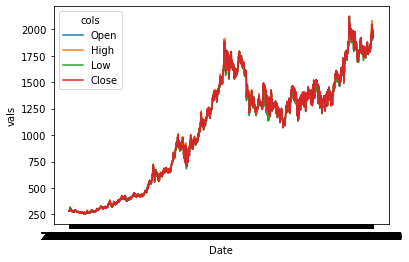

In [37]:
g = sns.lineplot(x="Date", y="vals", hue='cols', data=df_)

C:\Users\Alejandro\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

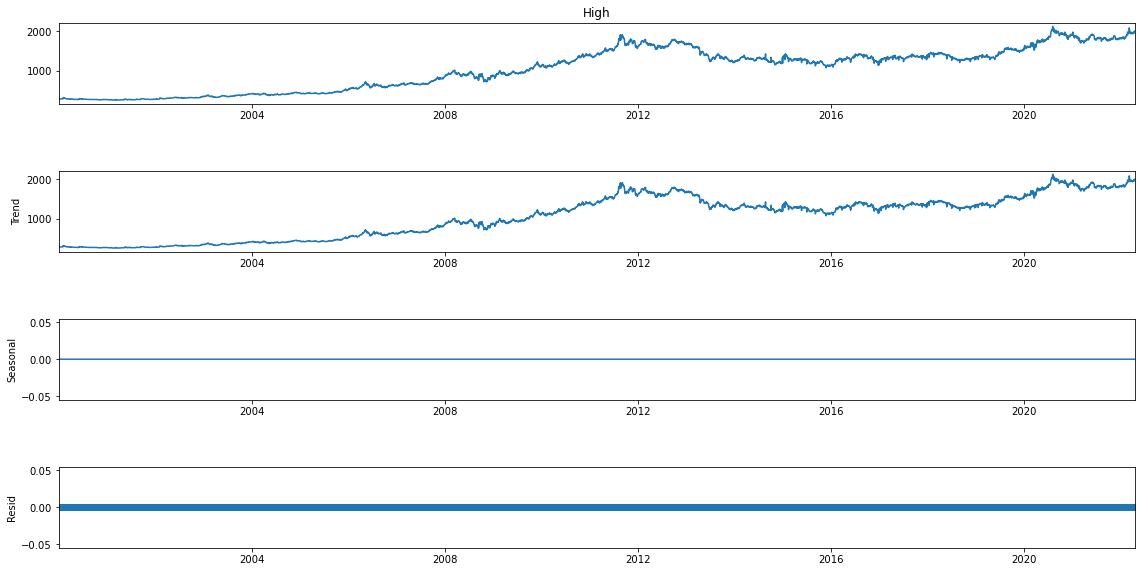

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(x=df['High'],model='additive', freq=1)
fig = plt.figure()
fig = result.plot()  
fig.set_size_inches(18, 9);

* No se aprecia influencia en ciertos periodos de tiempo en los valores. 
* Se aprecia una tendencia de aumento del valor
* No se aprecian outlayers

Creación de los datos de entrenamientos. Vamos a utilizar la variable ```High``` para la predicción. Como se aprecia en la gráfica son bastante parecidos los datos de las columnas.

In [5]:
set_train = df[:'2016'].iloc[:,1:2]

In [90]:
set_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4304 entries, 2000-01-04 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    4304 non-null   float64
dtypes: float64(1)
memory usage: 67.2 KB


In [6]:
set_test = df['2017':].iloc[:,1:2]

In [92]:
set_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1402 entries, 2017-01-02 to 2022-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    1402 non-null   float64
dtypes: float64(1)
memory usage: 21.9 KB


Escalamos los datos para el entrenamiento de la red LTSM

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
set_train_sc = sc.fit_transform(set_train)

In [8]:
#Ventana de tamaño 100
time_step = 100
X_train = []
Y_train = []
m = len(set_train_sc)

#Recorremos el dataset para crear las ventanas de tamaño 100 y la variable a predecir la 101
for i in range(time_step,m):
    X_train.append(set_train_sc[i-time_step:i,0])
    Y_train.append(set_train_sc[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Creación de la LTSM

In [9]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
units = 50

modelo_ltsm = Sequential()
modelo_ltsm.add(Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
modelo_ltsm.add(LSTM(units=units, input_shape=dim_entrada, return_sequences=True))
#Aplicamos Dropout para reducir el overfiting
modelo_ltsm.add(Dropout(0.20))
modelo_ltsm.add(LSTM(units=units))
modelo_ltsm.add(Dense(units=dim_salida))

modelo_ltsm.compile(optimizer='rmsprop', loss='mse')
modelo_ltsm.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 50)          22200     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 42,811
Trainable params: 42,811
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = modelo_ltsm.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
4204/4204 [==============================] - 8s 2ms/step - loss: 0.0064
Epoch 2/20
4204/4204 [==============================] - 8s 2ms/step - loss: 0.0024
Epoch 3/20
4204/4204 [==============================] - 8s 2ms/step - loss: 0.0020
Epoch 4/20
4204/4204 [==============================] - 8s 2ms/step - loss: 0.0016
Epoch 5/20
4204/4204 [==============================] - 8s 2ms/step - loss: 0.0014
Epoch 6/20
4204/4204 [==============================] - 8s 2ms/step - loss: 0.0013
Epoch 7/20
4204/4204 [==============================] - 8s 2ms/step - loss: 0.0011
Epoch 8/20
4204/4204 [==============================] - 8s 2ms/step - loss: 0.0010
Epoch 9/20
4204/4204 [==============================] - 8s 2ms/step - loss: 9.2749e-04
Epoch 10/20
4204/4204 [==============================] - 8s 2ms/step - loss: 9.1710e-04
Epoch 11/20
4204/4204 [==============================] - 8s 2ms/step - loss: 8.2523e-04
Epoch 12/20
4204/4204 [==============================] - 8s 2ms/step - lo

<Figure size 432x288 with 0 Axes>

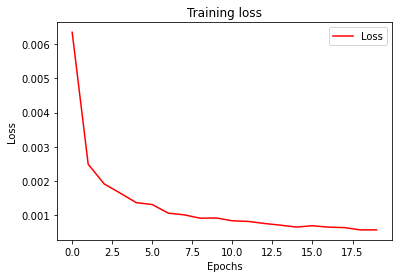

<Figure size 432x288 with 0 Axes>

In [99]:
# Recuperar una lista de resultados de la lista de datos de entrenamiento y pruebas para cada epoch de entrenamiento
loss=history.history['loss']

epochs=range(len(loss))

# Pérdida de entrenamiento y validación por epoch
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


Vemos como el valor de la perdida disminuye durante el entrenamiento

In [11]:
# Validación (predicción del valor de las acciones)
x_test = set_test.values
x_test = sc.transform(x_test)

# Recorremos el set de validación para dividirlo en el tamaño de la ventana
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

predicted = modelo_ltsm.predict(X_test)
predicted = sc.inverse_transform(predicted)

# Resultados

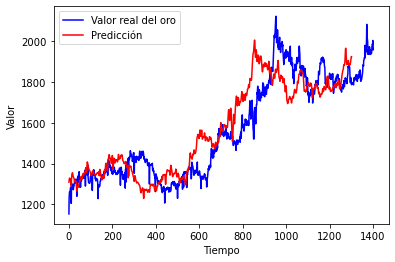

In [14]:
plt.plot(set_test.values,color='blue', label='Valor real del oro')
plt.plot(predicted, color='red', label='Predicción')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()


In [111]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


print('MAE: ', mean_absolute_error(set_test.values[:predicted.shape[0]], predicted)) 

print('RSME: ',  mean_squared_error(set_test.values[:predicted.shape[0]], predicted, squared=False))

MAE:  99.35788703977055
RSME:  122.98669614676244


Vemos como en la grafica el modelo se logra ajustar a la tendencia de la serie. Con un MAE y RSME aceptables comparados con el valor 

# Predicción de futuro

In [12]:
#Agregamos la nueva salida a la serie
timestep = 100
def insert_end(Xin,new_input):
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    return Xin

In [28]:
#Generamos las nuevas predicciones
future = 100
forcast = [] 
Xin = X_test[-1:]
for i in range(future):
    out = modelo_ltsm.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    Xin = insert_end(Xin,out[0,0])

In [29]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1,1) 
forcasted_output = sc.inverse_transform(forcasted_output) 

forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(pd.date_range(start='2022-03-21',periods=100,freq='D'))
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

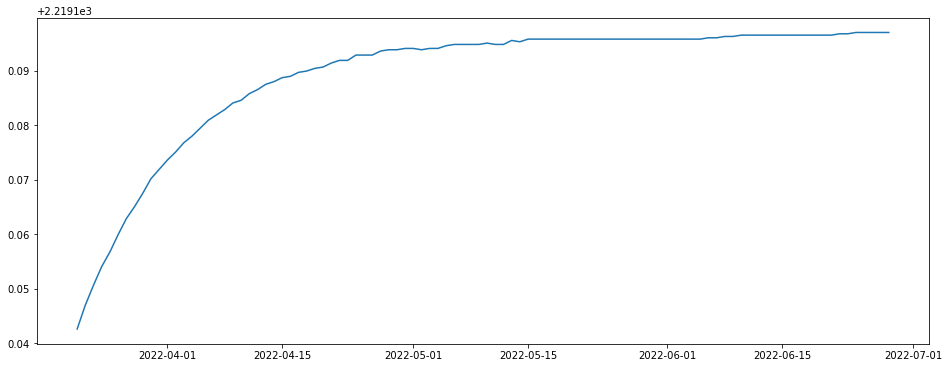

In [30]:
plt.figure(figsize=(16,6))
plt.plot(df_result.set_index('Date')[['Forecasted']]);

El limite del valor del oro nos indica un futuro improbable para ventanas muy grandes de tiempo.